In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

First we load up the data. This data corresponds to the 1-5 + 5-1 degenerate eigenmode.

In [2]:
data_filename = 'data/15_900_905_0.2.npy'
amplitude = np.load(data_filename)
summed_z = np.average(amplitude, 2)
print(data_filename)

data/15_900_905_0.2.npy


Here is the data without antialiasing:

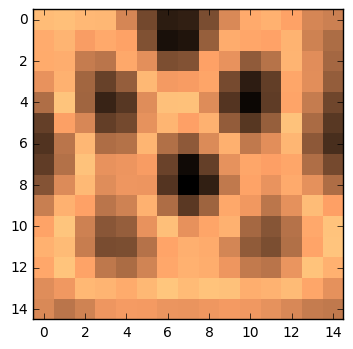

In [3]:
plt.imshow(summed_z, cmap='copper_r', interpolation='none')
plt.show()

Here is the data with antialising:

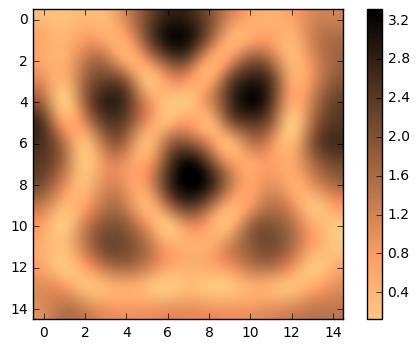

In [4]:
plt.imshow(summed_z, cmap='copper_r', interpolation='lanczos')
plt.colorbar()

We will always display our plots in this report in the antialiased form, as it is clearer. However, all analysis and calculations is done with the raw maps. 

Now, we generate a theoretical plot:

$f5(x)*f1(y)$ is 5-1. 

We have $f5(x)=0.583\cos(5 x) + 0.71429\cos(7 x)$, and $f1(x) = 0.75 (\cos(x) + 0.333\cos(3 x))$.

Here are the associated functions:

In [5]:
f1 = lambda x: 0.75*(np.cos(x) + 0.333*np.cos(3.*x))
f5 = lambda x: 0.583*np.cos(5.*x) + 0.71429*np.cos(7.*x)

Here is the range we are working over. Note that this range is approximate due to how well we know the sides of our plate:

In [6]:
steps_to_edge = 7950. #\pm 50
steps_taken_max = 5000. #(some data has 5000)
phase_at_edge = 1.0
phase_at_max = phase_at_edge*steps_taken_max/steps_to_edge
grid_size = 15
x_domain = np.linspace(-phase_at_edge, phase_at_edge, grid_size)
y_domain = np.copy(x_domain)

Now, we calculate the theoretical relative amplitude at each of these grid points:

In [7]:
five_one_theory_amplitude = np.dot(f5(x_domain)[:, None],f1(y_domain)[None])
one_five_theory_amplitude = np.dot(f1(x_domain)[:, None],f5(y_domain)[None])

Finally, here is the colormap of the 1-5+5-1 degenerate eigenmode, over our mapped region:

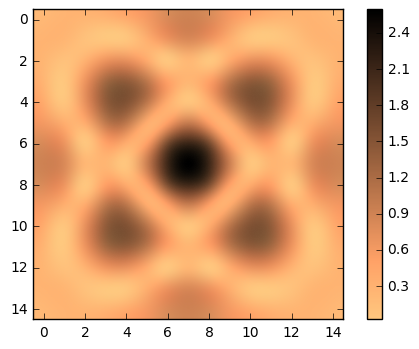

In [8]:
theoretical_mode = np.abs(one_five_theory_amplitude+five_one_theory_amplitude)
plt.imshow(theoretical_mode,
           cmap='copper_r', interpolation='lanczos')
plt.colorbar()

Here we find the indices of highest intensity - the ones that matter the most for our fit. We only pick the top percentile.

In [9]:
percentile = 0
high_indices = np.argwhere(theoretical_mode>=np.percentile(theoretical_mode, percentile))
left_indices = high_indices[:, 0]
right_indices = high_indices[:, 1]

In [10]:
fit = minimize(lambda a: np.sum(
        np.square((a*theoretical_mode[left_indices, right_indices] - \
                   summed_z[left_indices, right_indices])/\
                      0.1)
        ),
        x0=[1], method='Nelder-Mead')
a = fit.x[0]
fit

 final_simplex: (array([[ 1.63994141],
       [ 1.64003906]]), array([ 9827.02554773,  9827.02556627]))
           fun: 9827.0255477349274
       message: 'Optimization terminated successfully.'
          nfev: 30
           nit: 15
        status: 0
       success: True
             x: array([ 1.63994141])

# Here we calculate and plot the residuals of this fit:

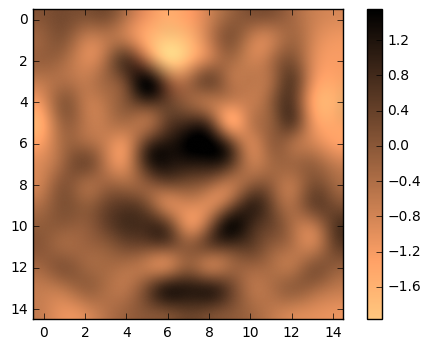

In [11]:
residuals = a*theoretical_mode-summed_z
plt.imshow(residuals, cmap='copper_r', interpolation='lanczos')
plt.colorbar()

In [12]:
reduced_chi_square = np.sum(np.square(residuals[left_indices, right_indices]/\
                                      0.1))/(left_indices.size-1)
reduced_chi_square

43.870649766673786

Now we create a full series of plots:

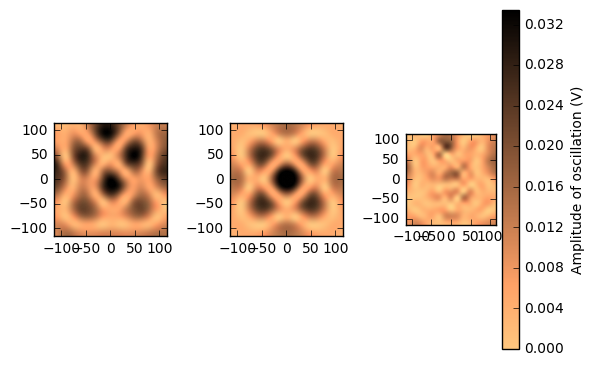

In [13]:
#See excel: calculation for C. 95.6 +- 0.4
ADC_to_voltage = 1./95.6
vmax = 3.2*ADC_to_voltage
mm_per_gridpoint = 16.485
fig = plt.figure()
plt.subplot2grid((1,3),(0, 0))
im1 = plt.imshow(
    summed_z*ADC_to_voltage, cmap='copper_r', interpolation='lanczos',
    vmin=0, vmax=vmax, extent=tuple(np.array([-7, 7, -7, 7])*mm_per_gridpoint))
#plt.xlabel("Sensor x-displacement from center of plate (mm)")
#plt.ylabel("Sensor x-displacement from center of plate (mm)")
plt.subplot2grid((1,3),(0, 1))
im2 = plt.imshow(theoretical_mode*a*ADC_to_voltage, cmap='copper_r', interpolation='lanczos',
    vmin=0, vmax=vmax, extent=tuple(np.array([-7, 7, -7, 7])*mm_per_gridpoint))
#plt.xlabel("Sensor x-displacement from center of plate (mm)")
#plt.ylabel("Sensor x-displacement from center of plate (mm)")
plt.subplot2grid((1,3),(0, 2))
im3 = plt.imshow(np.abs(theoretical_mode*a-summed_z)*ADC_to_voltage,
    cmap='copper_r', interpolation='lanczos',
    vmin=0, vmax=vmax, extent=tuple(np.array([-7, 7, -7, 7])*mm_per_gridpoint))
#plt.xlabel("Sensor x-displacement from center of plate (mm)")
#plt.ylabel("Sensor x-displacement from center of plate (mm)")
fig = plt.gcf()
fig.colorbar(im3, label='Amplitude of oscillation (V)')
fig.tight_layout()
fig.savefig("eigenmode_fitting2.pdf")

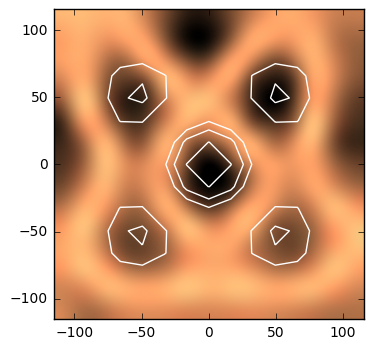

In [33]:
plt.imshow(
    summed_z*ADC_to_voltage, cmap='copper_r', interpolation='lanczos',
    vmin=0, vmax=vmax, extent=tuple(np.array([-7, 7, -7, 7])*mm_per_gridpoint))
plt.contour(theoretical_mode,
    vmin=0, vmax=vmax, extent=tuple(np.array([-7, 7, -7, 7])*mm_per_gridpoint),
   levels=np.logspace(0, 3, 20), colors='w')